In [217]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit.library import XGate, HGate, ZGate
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_city

In [218]:
num_input = 3
num_qubits = num_input * 2

In [219]:
def multi_cx(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    
    new_gate = XGate().control(num_controls, ctrl_state=ctrl_state)
    
    qc.append(new_gate, controls + anti_controls + [target])
    
    return qc

In [220]:
def multi_cz(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    new_gate = ZGate().control(num_controls, ctrl_state=ctrl_state)
    
    qc.append(new_gate, controls + anti_controls + [target])
    
    return qc

In [221]:
def get_ctrl_state(controls, anti_controls):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = ''
    for i in range(num_qubits - 1, -1, -1):
        if i in controls:
            ctrl_state += '1'
        elif i in anti_controls:
            ctrl_state += '0'
        else:
            pass
        pass
    return ctrl_state

In [222]:
def szegedy_step(qc):
    multi_cx(qc, [2], [num_input + 1, num_input + 2], num_input + 0)
    multi_cx(qc, [2], [num_input + 2], num_input + 1)
    qc.cx(2, num_input + 2)

    multi_cx(qc, [1], [num_input + 1], num_input + 0)
    qc.cx(1, num_input + 1)

    qc.cx(0, num_input + 0)

    multi_cx(qc, [], [num_input + 0], num_input + 1)
    qc.h(num_input + 0)
    multi_cz(qc, [num_input + 0], [num_input + 1], num_input + 2)
    qc.h(num_input + 0)
    multi_cx(qc, [], [num_input + 0], num_input + 1)

    multi_cx(qc, [2, num_input + 1, num_input + 2], [], num_input + 0)
    multi_cx(qc, [2, num_input + 2], [], num_input + 1)
    qc.cx(2, num_input + 2)

    multi_cx(qc, [1, num_input + 1], [], num_input + 0)
    multi_cx(qc, [1], [], num_input + 1)
    qc.cx(0, num_input + 0)

    # qc.swap(2, num_input + 2)
    # qc.swap(1, num_input + 1)
    # qc.swap(0, num_input + 0)
    
    # qc.draw(output="latex_source", filename="qcircuit.tex")
    qc.draw(output="mpl")

State vector: Statevector([ 3.22962861e-18+3.79079031e-34j,
             -7.71428750e-34-7.10391468e-34j,
             -7.71428750e-34-1.08947050e-33j,
              3.22962861e-18-1.49802194e-33j,
              7.07106781e-01-7.85046229e-17j,
             -1.30070718e-16+7.85046229e-17j,
              8.24496790e-17+7.85046229e-17j,
              7.07106781e-01+7.85046229e-17j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.0000

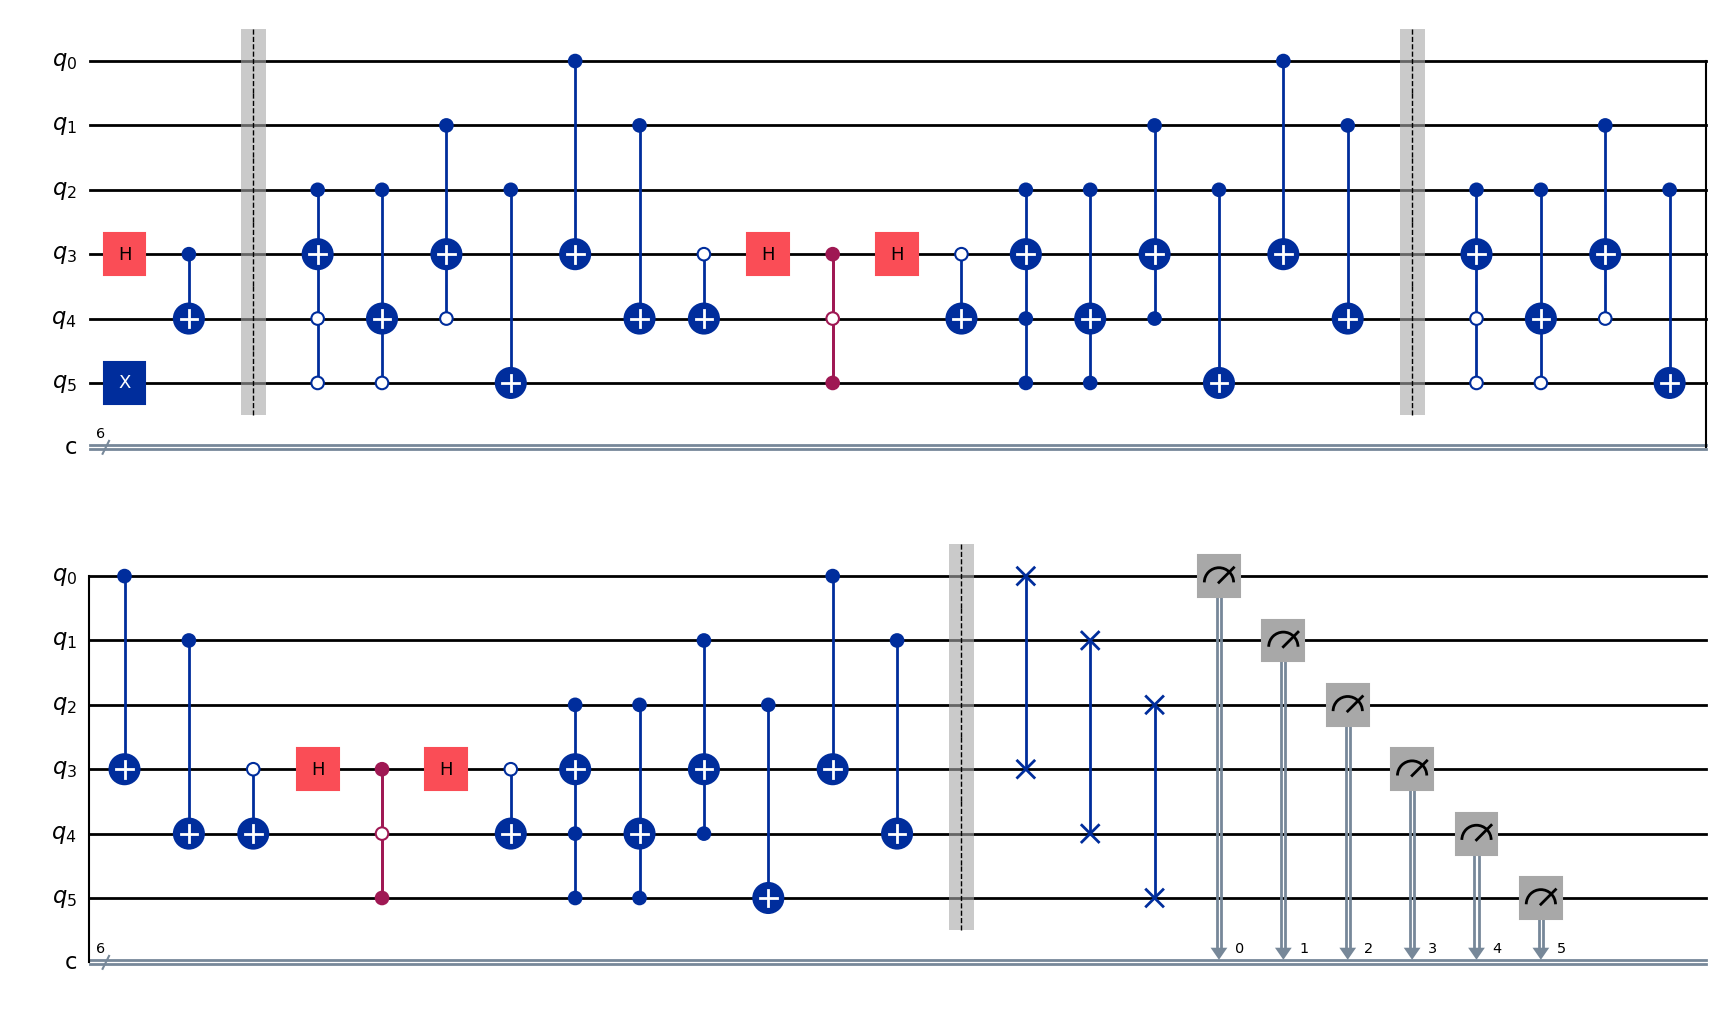

In [223]:
# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input * 2)

# Apply Hadamard coin operator
qc.h(num_input + 0)
qc.x(num_input + 2)
qc.cx(num_input + 0, num_input + 1)
# done with initail setup
qc.barrier()

for i in range(2):
    szegedy_step(qc)
    qc.barrier()
    

qc.swap(2, num_input + 2)
qc.swap(1, num_input + 1)
qc.swap(0, num_input + 0)


qc.remove_final_measurements()
state_vec = Statevector(qc)
print("State vector:", state_vec)

qc.measure(range(num_input*2), range(num_input*2))
# qc.measure_all()

qc.draw(output="mpl")



Measurement outcomes: {'000111': 511, '000100': 513}


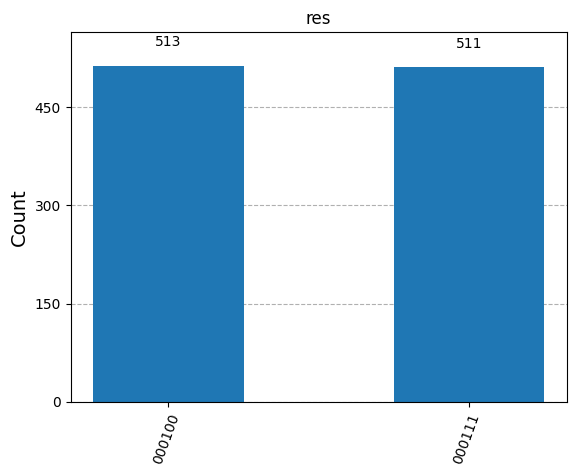

In [224]:

# Simulate the circuit
# simulator = Aer.get_backend("qasm_simulator")
simulator = AerSimulator()
qc = transpile(qc, simulator)
result = simulator.run(qc, shots=1024).result()
counts = result.get_counts(qc)

print("Measurement outcomes:", counts)
plot_histogram(counts, title='res')